## Imports ##

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from sklearn.manifold import TSNE

In [2]:
current_path = '/content/drive/MyDrive/Colab Notebooks/FacialClustering'

## NP Feature Extraction ##

In [5]:
# Load the Dataset
data_path = f'{current_path}/dataset/dataset'
image_files = []
labels = []

for file_name in os.listdir(data_path):
    if os.path.isfile(os.path.join(data_path, file_name)):
        image_files.append(os.path.join(data_path, file_name))
        labels.append(file_name)

# Feature Extraction
def extract_feature(image):
    # Apply any preprocessing if needed
    # Extract features using a pre-trained CNN or any other method
    # Placeholder function, replace with actual feature extraction
    feature_vector = np.random.rand(1000)  # Random feature vector, replace with actual features
    return feature_vector

feature_vectors = []
for image_file in image_files:
    image = cv2.imread(image_file)
    feature_vector = extract_feature(image)
    feature_vectors.append(feature_vector)

print('number of labels', len(labels))

# # Print features and labels
# for i in range(len(labels)):
#     print("Label:", labels[i])
#     print("Feature Vector:", feature_vectors[i])

# Saving Feature Vectors (optional)
np.save(f'{current_path}/feature_vectors.npy', feature_vectors)
np.save(f'{current_path}/labels.npy', labels)

175


## VGG16 Feature Extraction ##

In [3]:
# Load the Dataset
data_path = f'{current_path}/dataset/dataset'
image_files = []
labels = []

for file_name in os.listdir(data_path):
    if os.path.isfile(os.path.join(data_path, file_name)):
        image_files.append(os.path.join(data_path, file_name))
        labels.append(file_name)

# Feature Extraction using a pre-trained CNN (VGG16)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_feature(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    features = vgg16.predict(img_array)
    return features.flatten()

feature_vectors = []
for image_file in image_files:
    feature_vector = extract_feature(image_file)
    feature_vectors.append(feature_vector)

# Saving Feature Vectors
np.save(f'{current_path}/feature_vectors.npy', feature_vectors)
np.save(f'{current_path}/labels.npy', labels)


1/1 [==============================] - 1s 964ms/step


## PCA Dimension Reduction ##

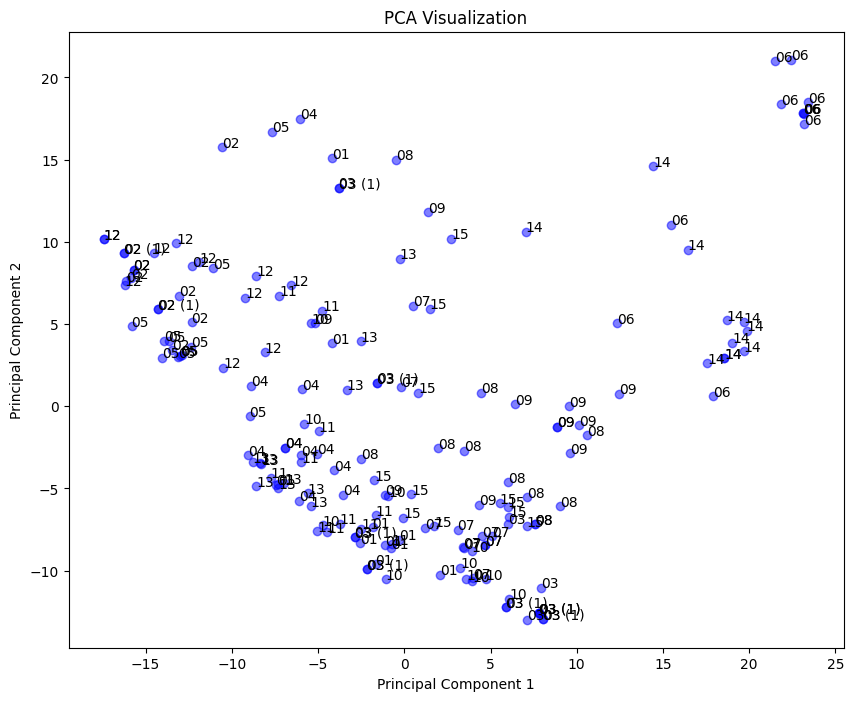

In [50]:
# Dimension Reduction
pca = PCA(n_components=175)  # You can choose the number of components based on your dataset
reduced_features = pca.fit_transform(feature_vectors)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c='blue', alpha=0.5)
for i in range(len(labels)):
    plt.text(reduced_features[i, 0], reduced_features[i, 1], labels[i].split('.')[0].split('subject')[1])
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## TSNE Dimension Reduction ##

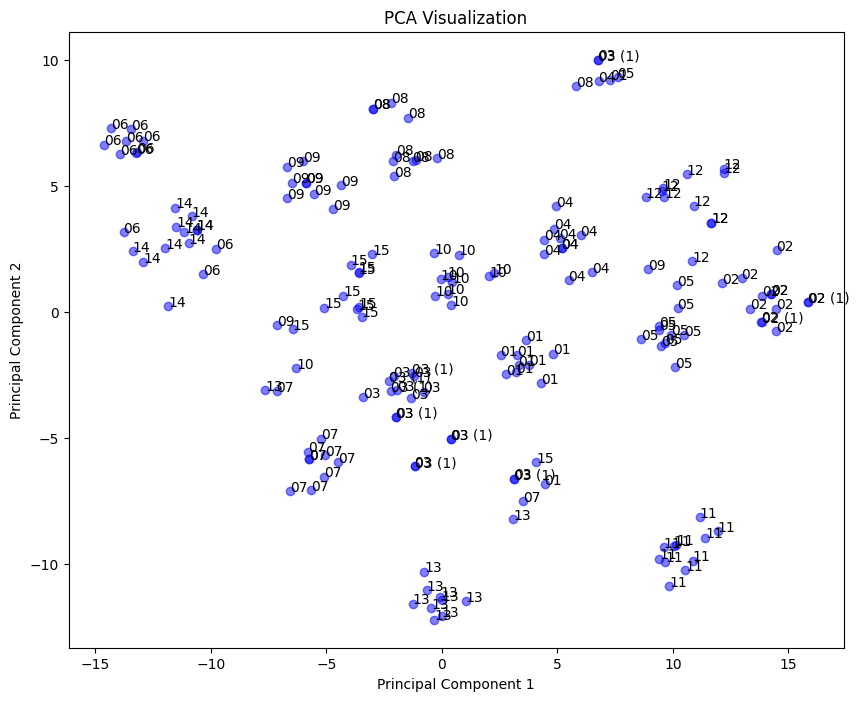

In [49]:
# Dimension Reduction using t-SNE
# Convert feature_vectors to a NumPy array
feature_vectors_array = np.array(feature_vectors)

# Dimension Reduction using t-SNE
tsne = TSNE(n_components=2)
reduced_features = tsne.fit_transform(feature_vectors_array)
# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c='blue', alpha=0.5)
for i in range(len(labels)):
    plt.text(reduced_features[i, 0], reduced_features[i, 1], labels[i].split('.')[0].split('subject')[1])
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Kmeans Clustering  ##

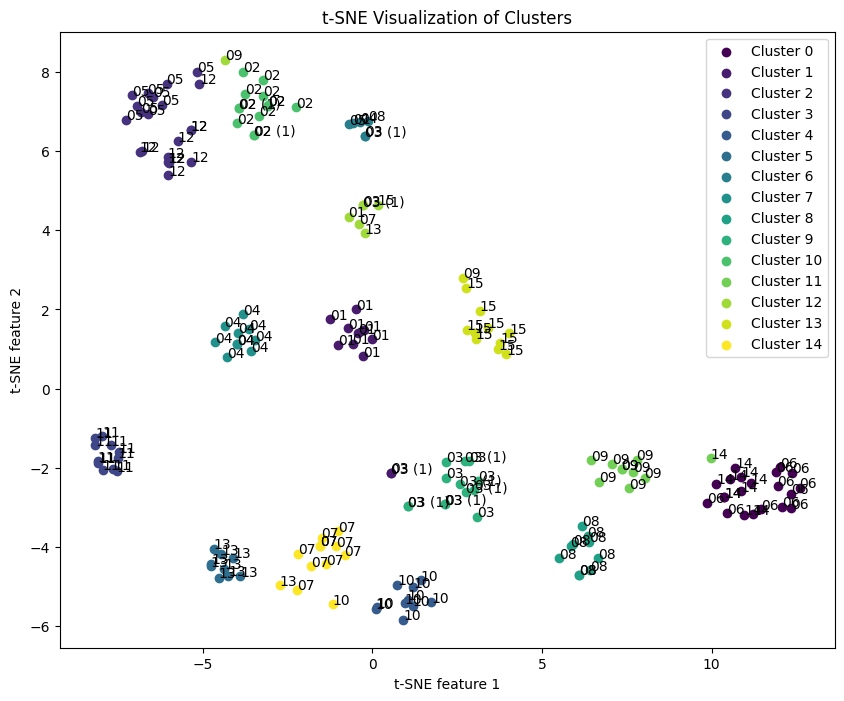

In [33]:
# Clustering
kmeans = KMeans(n_clusters=15)  # You can choose the number of clusters based on your dataset
clusters = kmeans.fit_predict(reduced_features)

# Visualization
tsne = TSNE(n_components=2)
embedded_features = tsne.fit_transform(reduced_features)

# Get unique cluster labels
unique_clusters = np.unique(clusters)

# Define colors for each cluster
cluster_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Plotting
plt.figure(figsize=(10, 8))
for i, cluster_label in enumerate(unique_clusters):
    cluster_indices = np.where(clusters == cluster_label)[0]
    plt.scatter(embedded_features[cluster_indices, 0], embedded_features[cluster_indices, 1], c=[cluster_colors[i]], label=f'Cluster {cluster_label}')

# Add labels
for i in range(len(embedded_features)):
    plt.text(embedded_features[i, 0], embedded_features[i, 1], labels[i].split('.')[0].split('subject')[1])

plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()

## DBSCAN Clustering  ##

17


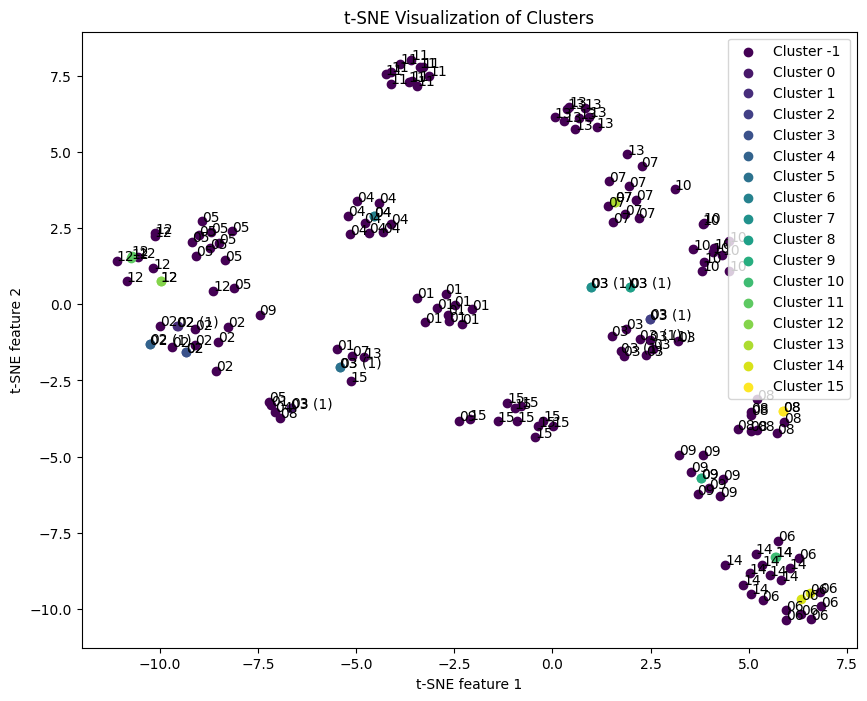

In [47]:
# Clustering
dbscan = DBSCAN(eps=0.1, min_samples=2)  # Adjust parameters as needed
clusters = dbscan.fit_predict(reduced_features)

# Visualization
tsne = TSNE(n_components=2)
embedded_features = tsne.fit_transform(reduced_features)

# Get unique cluster labels
unique_clusters = np.unique(clusters)
print(len(unique_clusters))

# Define colors for each cluster
cluster_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Plotting
plt.figure(figsize=(10, 8))
for i, cluster_label in enumerate(unique_clusters):
    cluster_indices = np.where(clusters == cluster_label)[0]
    plt.scatter(embedded_features[cluster_indices, 0], embedded_features[cluster_indices, 1], c=[cluster_colors[i]], label=f'Cluster {cluster_label}')

# Add labels
for i in range(len(embedded_features)):
    plt.text(embedded_features[i, 0], embedded_features[i, 1], labels[i].split('.')[0].split('subject')[1])

plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()
